In [ ]:
import torch
print(torch.__version__)

2.6.0+cu124


In [ ]:
!nvidia-smi

Thu Apr 17 01:23:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!python --version

Python 3.11.12


In [ ]:
# Install required libraries quietly
!pip install transformers evaluate wandb datasets accelerate -U peft bitsandbytes -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
## Setting Up the Environment
import os
from pathlib import Path

# Check if running in Google Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    # Mount Google Drive to access files
    drive.mount('/content/drive')


    # Set the base path to your specific Google Drive folder
    basepath = '/content/drive/MyDrive/HW7/'
    data_folder = Path(basepath) / 'data_folder/'
    # model_folder = Path(basepath) / 'sentiment' / 'nn'
    model_folder = Path(basepath) / 'model_checkpoints' / 'experiment_fulls'
    custom_functions = Path(basepath) / 'CustomFiles'

    # Create the necessary directories if they don't exist
    model_folder.mkdir(exist_ok=True, parents=True)
    custom_functions.mkdir(exist_ok=True, parents=True)
else:
    # Raise an error if not running in Google Colab
    raise EnvironmentError("This code is designed to run in Google Colab. Please switch to Google Colab to execute it.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Load the Libraries
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import gc
import time

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib

import torch
import torch.nn as nn
import ast


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

import wandb
from google.colab import userdata
from huggingface_hub import login


In [ ]:
set_seed(42)
import os
from huggingface_hub import login



# Retrieve Hugging Face token from environment variables
hf_token = os.getenv('HF_TOKEN')
login(token=hf_token)
print("Successfully logged into Hugging Face!")

Successfully logged into Hugging Face!


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import wandb

# Retrieve W&B API key from environment variables
wandb_api_key = os.getenv('WANDB_API_KEY')
wandb.login(key=wandb_api_key)
print("Successfully logged into W&B!")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged into W&B!


In [ ]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
base_folder = Path(basepath)
data_folder = base_folder/'datasets/Classification_HW/joblib_files'

In [ ]:
wandb.init(
    project="NLP_HW7",  # project name
    group="Exp_1_google/gemma",  # Group related runs under a specific experiment
    name="model_1",  # Set a unique name for each specific run
    )

wandb: Currently logged in as: dwivedi-anmol1996 (dwivedi-anmol1996-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin


# Loading the Dataset

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from datasets import Dataset

def prepare_dataset(csv_file_path, is_test=False):
    """
    Prepares a dataset for multi-label classification.

    Args:
        csv_file_path (str): Path to the CSV file.
        is_test (bool): Whether the dataset is for testing (no labels).

    Returns:
        Dataset: Hugging Face Dataset in the required format.
        list: Class names (only if not in test mode).
    """
    # Load the CSV dataset
    df = pd.read_csv(csv_file_path)

    # Define the emotion columns (labels)
    emotion_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

    if not is_test:
        # Combine the binary emotion labels into a list for each row
        df['labels'] = df[emotion_columns].apply(
            lambda x: [emotion for emotion, value in x.items() if value == 1], axis=1
        )

        # Keep only the 'Tweet' (renamed to 'text') and 'labels' columns
        df_final = df[['Tweet', 'labels']].rename(columns={'Tweet': 'text'})

        # One-hot encode the labels using MultiLabelBinarizer
        label_encoder = MultiLabelBinarizer()
        df_final['label'] = list(label_encoder.fit_transform(df_final['labels']))

        # Define class names for reference
        class_names = label_encoder.classes_

        # Convert to Hugging Face Dataset format
        dataset = Dataset.from_pandas(df_final[['text', 'label']])

        return dataset, class_names
    else:
        # For test data, only keep the 'Tweet' column, renamed to 'text'
        df_final = df[['Tweet']].rename(columns={'Tweet': 'text'})

        # Convert to Hugging Face Dataset format
        dataset = Dataset.from_pandas(df_final[['text']])

        return dataset


In [ ]:
# Prepare the training and validation datasets
train_data, class_names = prepare_dataset(csv_file_path='/content/drive/MyDrive/HW7/data_folder/train.csv', is_test=False)
test_data = prepare_dataset(csv_file_path='/content/drive/MyDrive/HW7/data_folder/test.csv', is_test=True)

In [ ]:
train_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 7724
 }),
 Dataset({
     features: ['text'],
     num_rows: 3259
 }))

In [ ]:
train_data['label'][0]

[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]

In [ ]:
test_data

Dataset({
    features: ['text'],
    num_rows: 3259
})

# Splitting the Training Data into Train and Validation Data

In [ ]:
# Unpack if train_data is a tuple
if isinstance(train_data, tuple):
    train_data, class_names = train_data

# Split the existing train_data into train and validation sets
train_valid_split = train_data.train_test_split(test_size=0.1, seed=42)

# Rename the splits for clarity
train_data = train_valid_split['train']
valid_data = train_valid_split['test']

# Now we have:
# - train_data: for training
# - valid_data: for validation during training
# - test_data: as the final unseen test data

print("Train Data:", train_data)
print("Valid Data:", valid_data)
print("Test Data (Unseen):", test_data)

In [ ]:
train_val_subset= DatasetDict(
    {"train": train_data, "valid": valid_data})

train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6951
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 773
    })
})

In [ ]:
train_val_subset['train']['label'][0]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]

In [ ]:
test_data

Dataset({
    features: ['text'],
    num_rows: 3259
})

# Load Pre-Trained Tokenizer

In [ ]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [ ]:
free_gpu_memory()

In [ ]:
checkpoint = "google/gemma-2-2b"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

## Create Function for Tokenizer

In [ ]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True, max_length=512)

In [ ]:
tokenized_dataset= train_val_subset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6951
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 773
    })
})

In [ ]:
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset['train']['label'][0:3]

tensor([[1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]])

# Model Training

## Download pre-trained model

In [ ]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16


torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [ ]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,)

config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at google/gemma-2-2b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Download and Modify Model Config File

In [ ]:
class_names

array(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
       'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
      dtype=object)

In [ ]:
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
config.id2label = id2label
config.label2id = label2id
model.config = config

## PEFT Setup

In [ ]:
model

Gemma2ForSequenceClassification(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforw

In [ ]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [ ]:
find_linear_layers(model)

['q_proj',
 'k_proj',
 'v_proj',
 'score',
 'down_proj',
 'o_proj',
 'up_proj',
 'gate_proj']

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="all",
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

In [ ]:
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Gemma2ForSequenceClassification(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleD

In [ ]:
for name, param in lora_model.named_parameters():
    print(f"{name}: {param.requires_grad}")

## Compute Function

In [ ]:
# load training metrices
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    preds = (logits > 0).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

## Training Arguments

In [ ]:
# Define the directory where model checkpoints will be saved
model_folder = Path("/content/gemma_lora_imb")
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'stack_exp_imb_exp1'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = TrainingArguments(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)

In [ ]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    lora_model.config.use_cache = False  # Disable caching for compatibility

lora_model.config

Gemma2Config {
  "_name_or_path": "google/gemma-2-2b",
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 8192,
  "model_type": "gemma2",
 

## Initialize Trainer

In [ ]:
tokenized_dataset['train']['label']

tensor([[1., 0., 1.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

In [ ]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

In [ ]:
pos_weights = calculate_pos_weights(tokenized_dataset)

In [ ]:
pos_weights

tensor([ 1.6869,  6.0569,  1.6450,  4.6975,  1.6952,  8.3427,  2.3891,  7.6134,
         2.3743, 18.8034, 18.7472])

In [ ]:
pos_weights

tensor([ 1.6869,  6.0569,  1.6450,  4.6975,  1.6952,  8.3427,  2.3891,  7.6134,
         2.3743, 18.8034, 18.7472])

In [ ]:
# initialize trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 6951
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 773
    })
})

In [ ]:
# lora_model.config.use_cache = False
trainer = CustomTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

<ipython-input-47-fcc51a4c04a4>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


## Training and Validataion

In [ ]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy Label,Accuracy All
20,2.269500,1.785225,0.348440,0.320287,0.555333,0.001294
40,1.455900,1.332462,0.398622,0.362984,0.610020,0.003881
60,1.182700,1.056728,0.462349,0.430953,0.664119,0.007762
80,0.923100,0.983090,0.576734,0.485499,0.766788,0.047865
100,0.915300,0.901334,0.563969,0.502947,0.744678,0.025873
120,0.824300,0.835756,0.563726,0.517325,0.741150,0.024580
140,0.804400,0.830683,0.555689,0.524728,0.738210,0.018111
160,0.769000,0.786701,0.608031,0.548434,0.783018,0.058215
180,0.737000,0.783793,0.597715,0.543147,0.772198,0.037516
200,0.730900,0.760811,0.630945,0.566623,0.798306,0.082794


In [ ]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [ ]:
eval_results

{'eval_loss': 0.7266362309455872,
 'eval_f1_micro': 0.6504961411245865,
 'eval_f1_macro': 0.5890363575849258,
 'eval_accuracy_label': 0.81359520169352,
 'eval_accuracy_all': 0.12419146183699871,
 'eval_runtime': 8.5838,
 'eval_samples_per_second': 90.053,
 'eval_steps_per_second': 5.708,
 'epoch': 1.9954022988505749}

In [ ]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"], "eval_accuracy": eval_results["eval_accuracy_all"]})

In [ ]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset["valid"])

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)
valid_labels = np.array(valid_output.label_ids.astype(int))

In [ ]:
valid_logits.shape

(773, 11)

In [ ]:
valid_probs.shape

(773, 11)

In [ ]:
valid_labels.shape

(773, 11)

In [ ]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics



In [ ]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)


In [ ]:
optimal_thresholds

[0.5992506742477417,
 0.5019378662109375,
 0.4857841730117798,
 0.6414374113082886,
 0.6334097981452942,
 0.7037490606307983,
 0.44830775260925293,
 0.7634837031364441,
 0.6183195114135742,
 0.9059898257255554,
 0.7013039588928223]

In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [ ]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_micro': 0.6908817635270541,
 'f1_macro': 0.6121097474242924,
 'accuracy_label': 0.8548747500882041,
 'accuracy_all': 0.18369987063389392}

In [ ]:
valid_preds = (valid_probs > optimal_thresholds).astype(int)
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


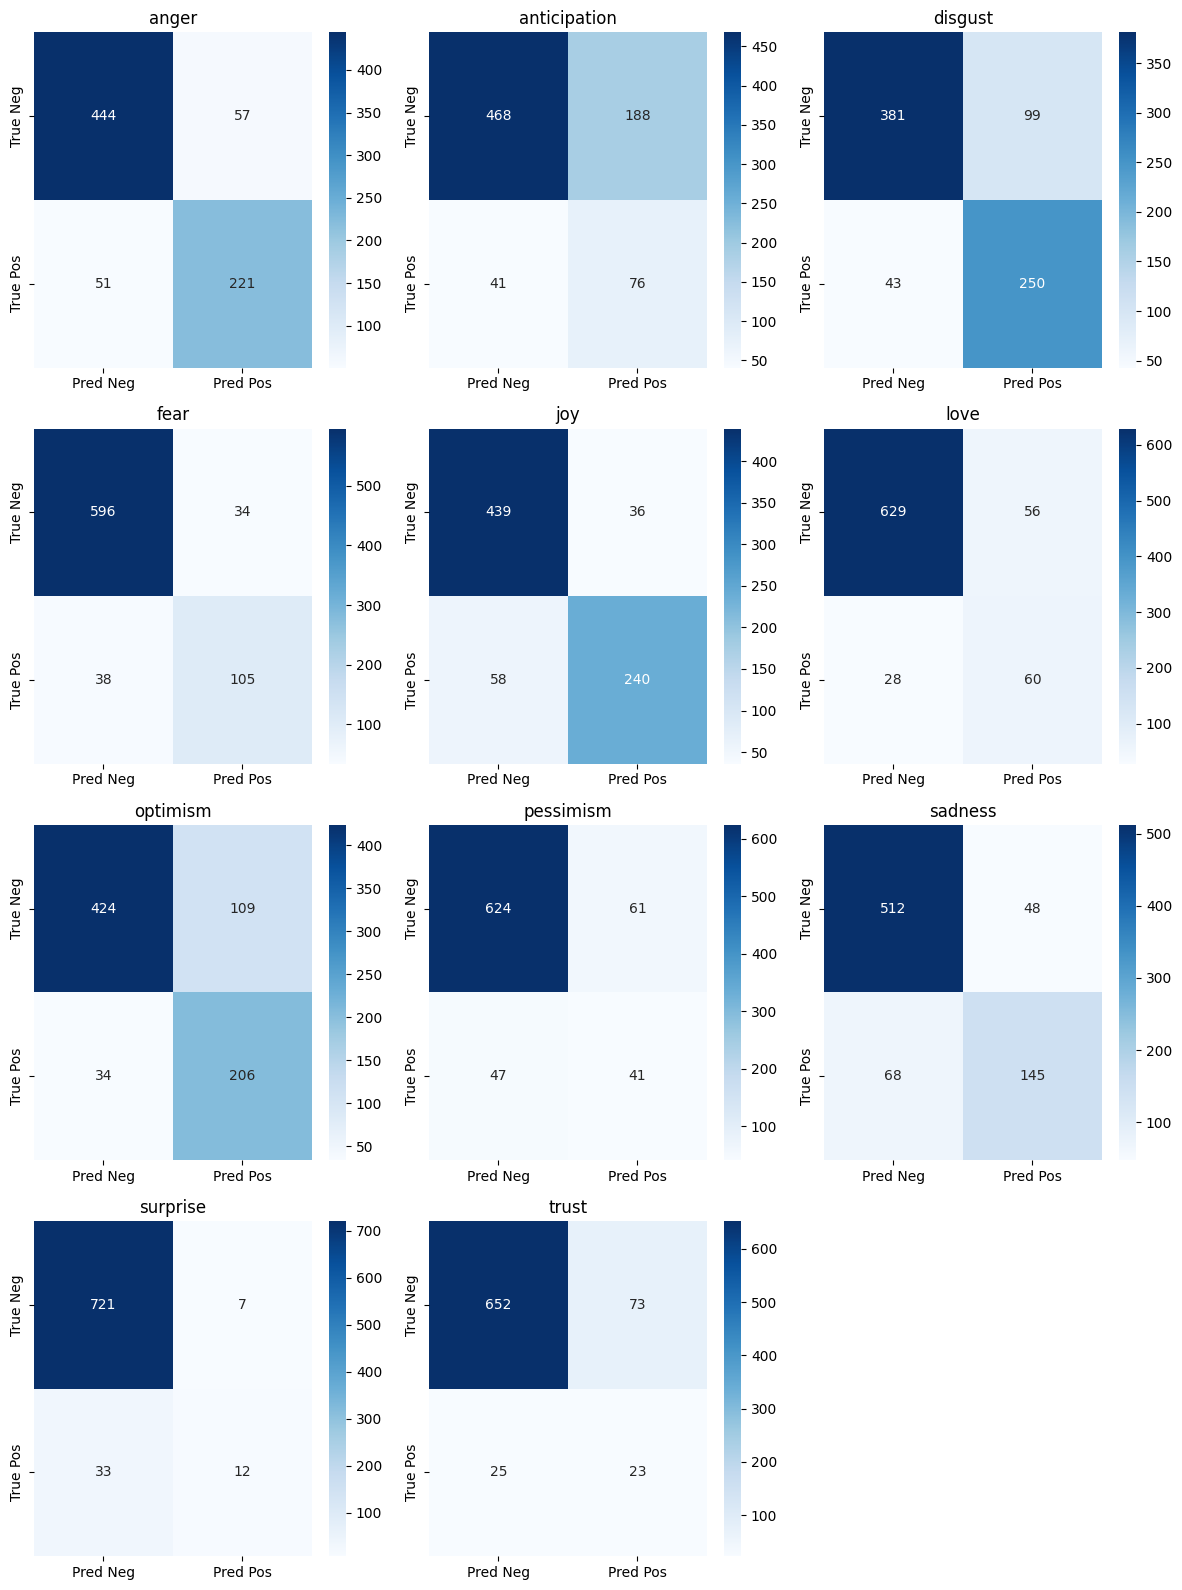

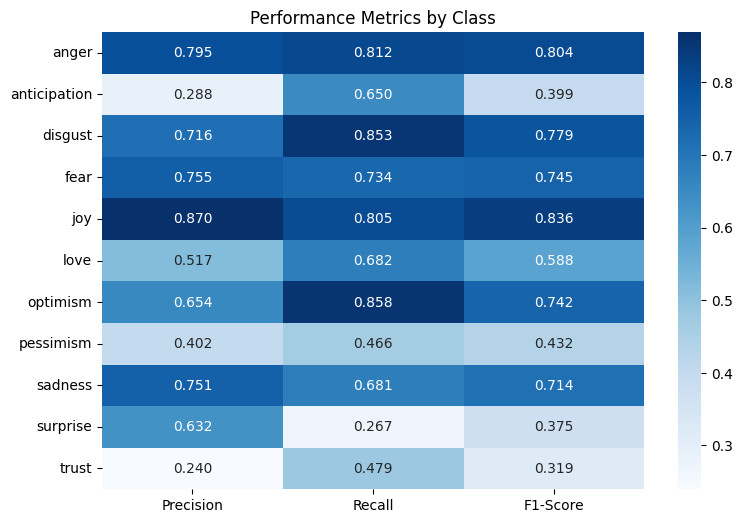

<Figure size 1200x533.333 with 0 Axes>

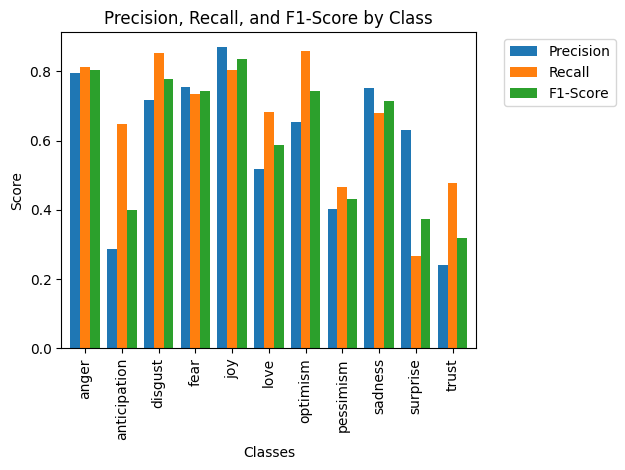

{'macro_avg': {'precision': 0.6017967391641316,
  'recall': 0.6625086313888304,
  'f1': 0.6121097474242924},
 'per_class': {'Precision': {'anger': 0.7949640287769785,
   'anticipation': 0.2878787878787879,
   'disgust': 0.7163323782234957,
   'fear': 0.7553956834532374,
   'joy': 0.8695652173913043,
   'love': 0.5172413793103449,
   'optimism': 0.653968253968254,
   'pessimism': 0.4019607843137255,
   'sadness': 0.7512953367875648,
   'surprise': 0.631578947368421,
   'trust': 0.23958333333333334},
  'Recall': {'anger': 0.8125,
   'anticipation': 0.6495726495726496,
   'disgust': 0.8532423208191127,
   'fear': 0.7342657342657343,
   'joy': 0.8053691275167785,
   'love': 0.6818181818181818,
   'optimism': 0.8583333333333333,
   'pessimism': 0.4659090909090909,
   'sadness': 0.6807511737089202,
   'surprise': 0.26666666666666666,
   'trust': 0.4791666666666667},
  'F1-Score': {'anger': 0.8036363636363636,
   'anticipation': 0.3989501312335958,
   'disgust': 0.778816199376947,
   'fear': 

In [ ]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=class_names, figsize=(12, 8))

In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

# Performance on Test Set

In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/gemma_lora_imb/checkpoint-420'

In [ ]:
from peft import AutoPeftModelForSequenceClassification, PeftConfig

In [ ]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# 3. Set model to evaluation mode
model.eval()

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at google/gemma-2-2b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Gemma2ForSequenceClassification(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleD

In [ ]:
# Function to tokenize text data
def tokenize_fn(batch):
    return tokenizer(text=batch["text"], truncation=True, max_length=512)

# Tokenize the unseen test data
test_set_tokenized = test_data.map(tokenize_fn, batched=True)
test_set_tokenized = test_set_tokenized.remove_columns(['text'])
test_set_tokenized.set_format(type='torch')

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
test_set_tokenized

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 3259
})

In [ ]:
# test_set_tokenized.set_format(type='torch')
# test_set_tokenized = (test_set_tokenized
#           .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
#           .rename_column("float_label", "label"))

In [ ]:
training_args = TrainingArguments(
    seed = 42,
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

## Instantiate Trainer

In [ ]:
from functools import partial

In [ ]:
compute_metrics_fn = partial(compute_metrics, thresholds=optimal_thresholds)

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics_fn,
    tokenizer=tokenizer,
)

<ipython-input-94-b7cbf9c7164a>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


## Evaluate Using Trainer

In [ ]:
test_results= trainer.evaluate()

In [ ]:
test_results

{'eval_model_preparation_time': 0.0076,
 'eval_runtime': 30.0924,
 'eval_samples_per_second': 108.3,
 'eval_steps_per_second': 0.864}

In [ ]:
wandb.log({
    "test_f1_macro": test_results.get("eval_f1_macro", None),
    "test_loss": test_results.get("eval_loss", None),
    "test_accuracy": test_results.get("eval_accuracy_all", None)
})


In [ ]:
wandb.finish()

eval/accuracy_all,▁▁▁▄▂▂▂▄▃▆▇▆▆█▇▆▇█▆▇██
eval/accuracy_label,▁▂▄▇▆▆▆▇▇▇▇▇▇█████████
eval/f1_macro,▁▂▄▅▆▆▆▇▇▇▇▇██████████
eval/f1_micro,▁▂▄▆▆▆▆▇▇█▇█▇█████████
eval/loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▆▄▆▅▅▅▃▇▇▂▇▇▃▄█▇▅▇▃▁▅█
eval/samples_per_second,▃▅▃▄▄▄▆▂▂▆▂▂▆▅▁▂▄▂▆█▄▁
eval/steps_per_second,▃▅▃▄▄▄▆▂▂▆▂▂▆▅▁▂▄▂▆█▄▁
eval_accuracy,▁
eval_f1_macro,▁
eval_loss,▁


# Model Inference

In [ ]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model.config.use_cache = False
# 3. Set model to evaluation mode
model.eval()
model.config.use_cache = False

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at google/gemma-2-2b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config

Gemma2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/gemma-2-2b",
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10"
  },
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "max_pos

In [ ]:
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
model.config.id2label = id2label
model.config.label2id = label2id

In [ ]:
custom_pipeline = pipeline(
    task="text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    function_to_apply='sigmoid')

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForS

In [ ]:
sample = valid_data['text'][0]
preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.01912403479218483},
  {'label': 'anticipation', 'score': 0.8187368512153625},
  {'label': 'disgust', 'score': 0.16344542801380157},
  {'label': 'fear', 'score': 0.7310585975646973},
  {'label': 'joy', 'score': 0.6901415586471558},
  {'label': 'love', 'score': 0.1766716092824936},
  {'label': 'optimism', 'score': 0.5626571774482727},
  {'label': 'pessimism', 'score': 0.22135066986083984},
  {'label': 'sadness', 'score': 0.2628418207168579},
  {'label': 'surprise', 'score': 0.6113819479942322},
  {'label': 'trust', 'score': 0.2465333193540573}]]

In [ ]:
def get_positive_labels(pipeline_output, optimal_thresholds):

   positive_labels = []

   for pred_set in pipeline_output:
       # Get scores for all labels
       scores = [pred['score'] for pred in pred_set]
       labels = [pred['label'] for pred in pred_set]

       # Get positions where score > threshold for that label
       sample_positives = [
           label for label, score, threshold in zip(labels, scores, optimal_thresholds)
           if score >= threshold
       ]

       positive_labels.append(sample_positives)

   return positive_labels


In [ ]:
def get_positive_labels(pipeline_output, optimal_thresholds):

   positive_labels = []

   for pred_set in pipeline_output:
       # Get scores for all labels
       scores = [pred['score'] for pred in pred_set]
       labels = [pred['label'] for pred in pred_set]

       # Get positions where score > threshold for that label
       sample_positives = [
           label for label, score, threshold in zip(labels, scores, optimal_thresholds)
           if score >= threshold
       ]

       positive_labels.append(sample_positives)

   return positive_labels


In [ ]:
results = get_positive_labels(preds, optimal_thresholds)
results

[['anticipation', 'fear', 'joy', 'optimism']]

#Model Output Logging

In [ ]:
def prepare_dataset(csv_file_path, is_test=False):
    """
    Prepares a dataset for multi-label classification.

    Args:
        csv_file_path (str): Path to the CSV file.
        is_test (bool): Whether the dataset is for testing (no labels).

    Returns:
        Dataset: Hugging Face Dataset in the required format.
        list: Class names (only if not in test mode).
    """
    # Load the CSV dataset
    df = pd.read_csv(csv_file_path)

    # Define the emotion columns (labels)
    emotion_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

    if not is_test:
        # Combine the binary emotion labels into a list for each row
        df['labels'] = df[emotion_columns].apply(
            lambda x: [emotion for emotion, value in x.items() if value == 1], axis=1
        )

        # Keep only the 'Tweet' (renamed to 'text') and 'labels' columns
        df_final = df[['Tweet', 'labels']].rename(columns={'Tweet': 'text'})

        # One-hot encode the labels using MultiLabelBinarizer
        label_encoder = MultiLabelBinarizer()
        df_final['label'] = list(label_encoder.fit_transform(df_final['labels']))

        # Define class names for reference
        class_names = label_encoder.classes_

        # Convert to Hugging Face Dataset format
        dataset = Dataset.from_pandas(df_final[['text', 'label']])

        return dataset, class_names
    else:
        # For test data, keep the 'ID' and 'Tweet' columns, renaming 'Tweet' to 'text'
        df_final = df[['ID', 'Tweet']].rename(columns={'Tweet': 'text'})

        # Convert to Hugging Face Dataset format
        dataset = Dataset.from_pandas(df_final[['ID', 'text']])

        return dataset


In [ ]:
# Load and prepare the test dataset
test_data = prepare_dataset(csv_file_path='/content/drive/MyDrive/HW7/data_folder/test.csv', is_test=True)

In [ ]:
# Tokenize the unseen test data
test_set_tokenized = test_data.map(tokenize_fn, batched=True)
test_set_tokenized = test_set_tokenized.remove_columns(['text'])
test_set_tokenized.set_format(type='torch')

# Use `predict` to generate predictions
test_output = trainer.predict(test_set_tokenized)
test_logits = test_output.predictions

# Convert logits to probabilities using sigmoid
test_probs = sigmoid(test_logits)

# Apply optimal thresholds to obtain binary predictions
test_preds = (test_probs > optimal_thresholds).astype(int)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
# Retrieve the IDs from the original test data
ids = test_data['ID']

# Define the class names
emotion_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                   'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Create a DataFrame with the predictions and IDs
submission_df = pd.DataFrame(test_preds, columns=emotion_columns)
submission_df['ID'] = ids  # Add the 'ID' column

# Reorder the columns to have 'ID' as the first column
submission_df = submission_df[['ID'] + emotion_columns]

# Save to CSV for Kaggle submission
submission_df.to_csv("submission_model_1.csv", index=False)
